In [1]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
    CompoundNormSpectralModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/')
sys.path.append('../')
from Dataset_Creation import sys_dataset
import Dataset_load 

In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [3]:
path_public_pks = "../PKS_flare/HESS_public/"

In [4]:
#path_public_crab = "../Crab/HESS_public/"
#sys_percentage = np.loadtxt(path_public_crab+"sysamplitude_percentage.txt")
sys_percentage = np.array([10] * 24)

In [5]:
pksflare_dataset = MapDataset.read(path_public_pks+"dataset-stacked.fits.gz")

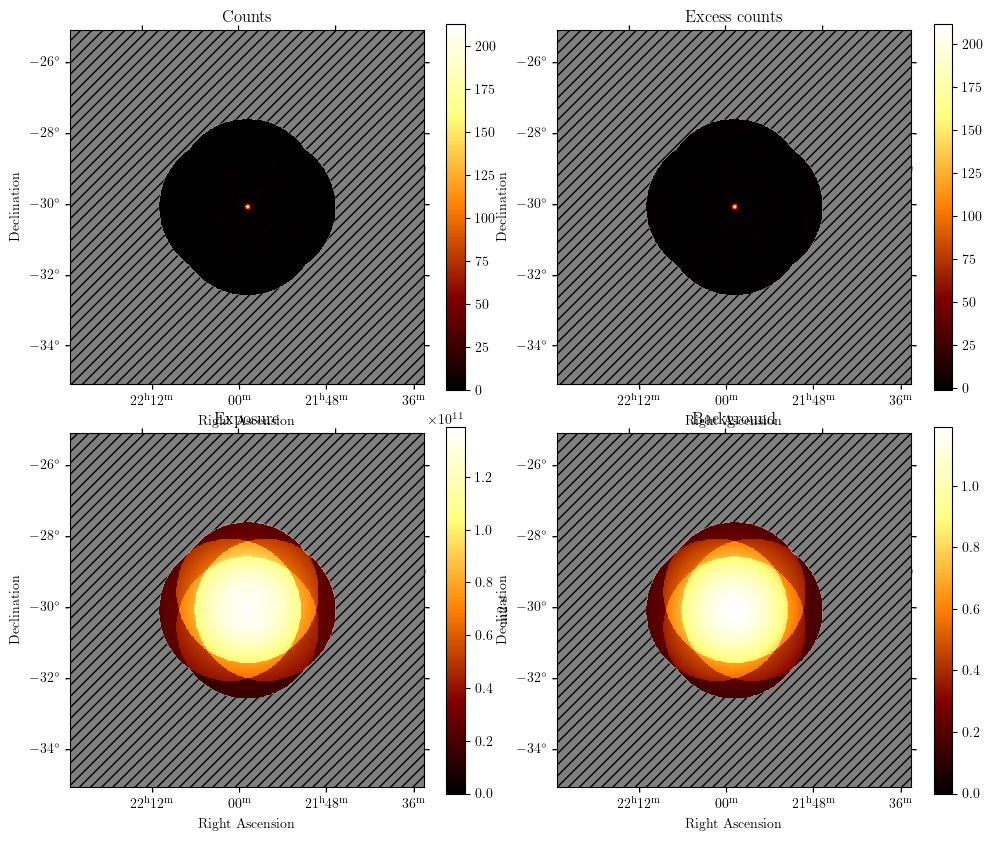

In [6]:
pksflare_dataset.peek()

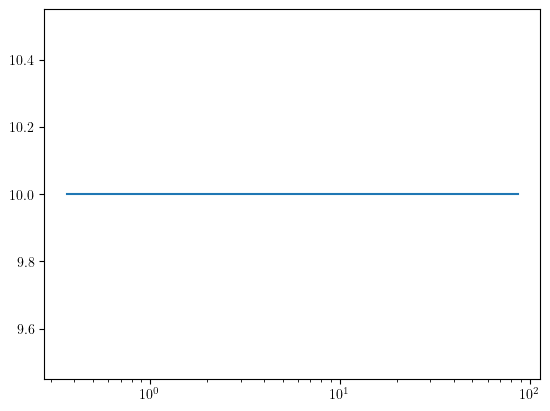

In [7]:
emask = pksflare_dataset.mask.data.sum(axis=2).sum(axis=1)>0
energy = pksflare_dataset.geoms['geom'].axes[0].center[emask]
plt.plot(energy, sys_percentage[emask])
plt.xscale('log')

In [8]:
powerlaw = Models.read(path_public_pks+"model-pl.yaml")
powerlaw_published = Models.read(path_public_pks+"model-pl.yaml")

bkg = FoVBackgroundModel(dataset_name=pksflare_dataset.name)
bkg.parameters['tilt'].frozen = False

pksflare_dataset.models = Models([powerlaw[0], bkg])
print(pksflare_dataset.models)

DatasetModels

Component 0: SkyModel

  Name                      : aEaZD8Bs
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   4.11e-11   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : stacked-bkg
  Datasets names            : ['stacked']
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                          :      0.000   +/-    0.00             
    referen

In [9]:
%%time
fit = Fit()
fit.run(pksflare_dataset)

CPU times: user 17.6 s, sys: 5.09 s, total: 22.7 s
Wall time: 22.8 s


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 184
	total stat : 198873.76

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

In [10]:
print(pksflare_dataset.models)

DatasetModels

Component 0: SkyModel

  Name                      : aEaZD8Bs
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      3.429   +/-    0.02             
    amplitude                     :   7.53e-11   +/- 1.2e-12 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.717   +/-    0.00 deg         
    lat_0                         :    -30.225   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : stacked-bkg
  Datasets names            : ['stacked']
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm                          :      0.982   +/-    0.01             
    tilt                          :     -0.005   +/-    0.01             
    referen

/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1134: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


(<WCSAxes: >,
 <Axes: xlabel='Energy [TeV]', ylabel='Residuals ((data - model) / sqrt(model))'>)

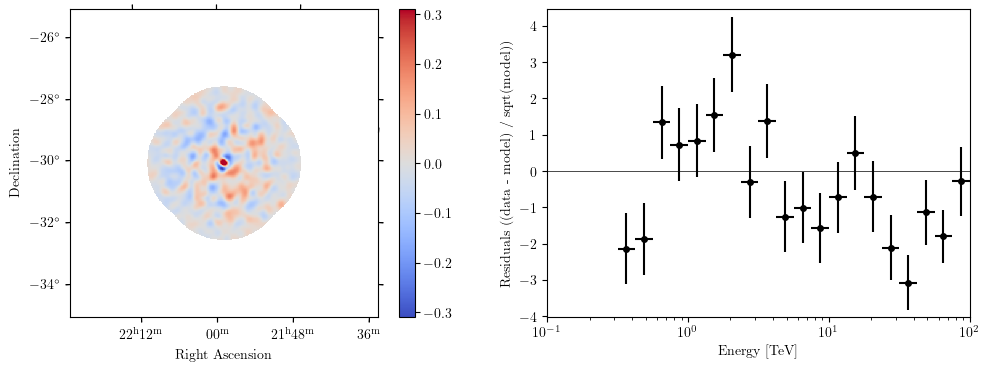

In [11]:
pksflare_dataset.plot_residuals(kwargs_spatial={'vmax':0.31,
                                      'vmin':-0.31},
                      kwargs_spectral={'method' : 'diff/sqrt(model)'})

In [12]:
def plot_par(par1, par2, label,ax = None, fmt ='x', markersize = 6, color = 'red'):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.errorbar(x = par1.value, y = par2.value, xerr = par1.error, yerr = par2.error, fmt= fmt,
                markersize = markersize,
                label = label, color = color)
    ax.set_xlabel(f"{par1.name} [{par1.unit}] " )
    ax.set_ylabel(f"{par2.name} [{par2.unit}] " )
    ax.legend()
    
    return ax

def plot_source_par(model_name, pars):
    if len(pars)>2:
        fig, ax = plt.subplots(2,2, figsize = (6,6))
        ax = ax.flatten()
    else:
        fig, ax = plt.subplots(1,2, figsize = (6,3))
   
    for i, p in enumerate(pars):
    
        for j, m in enumerate (models_list):
            #try:
            plot_par(m.parameters[p[0]],
                 m.parameters[p[1]],
                    label= labels[j],
                    ax = ax[i],
                    fmt = fmts[j],
                    markersize = markersize[j], 
                        color = colors [j])
            #except:
            #    pass

    plt.tight_layout()
    return fig

labels = [ 'fitted', 'fitted with BKG sys']
fmts = ['o','x', '*']
markersize = [6,10, 10]

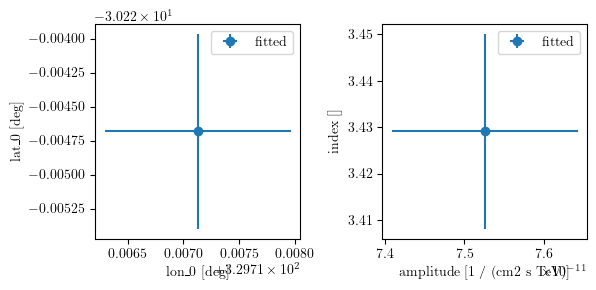

In [13]:
models_list = [ pksflare_dataset.models, ]
colors = ['tab:blue', 'tab:orange', 'tab:green']
pars =  pars = [('lon_0', 'lat_0'),('amplitude', 'index'),]
fig = plot_source_par(0, pars)


## BKG Energybin wise systematic

In [14]:
l = len(energy)
norms = Parameters([Parameter ("norm"+str(i), value = 0, is_penalised = True, 
                               frozen = True) for i in range(len(energy))])
for i in range(len(norms)):
    if sys_percentage[i] > 0:
        norms[i].frozen = False
piece = PiecewiseNormSpectralModel(energy = energy,
                          norms = norms)

import operator
bkg_spectral = CompoundNormSpectralModel(model1 = piece, 
                                        model2 = PowerLawNormSpectralModel(),
                                        operator= operator.add)

pksflare_dataset_sys = pksflare_dataset.copy(name = "Crab sys")
bkg_sys = FoVBackgroundModel(spectral_model = bkg_spectral,
                            dataset_name= pksflare_dataset_sys.name)
bkg_sys.parameters['tilt'].frozen = False
pksflare_dataset_sys.models = Models([powerlaw_published[0].copy(), 
                                bkg_sys])

0.10000000000100001


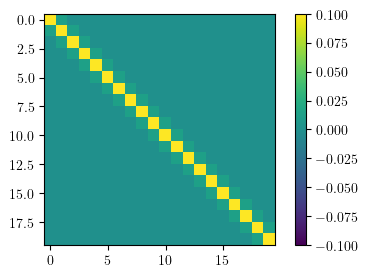

In [15]:
from scipy.stats import norm
l = len(energy) 
cov = np.ones((l,l)) * 1e-12
cov = np.identity(l)

# note: values set arbitrarily 
for i in range(l):
    if sys_percentage[emask][i] > 0:
        gau = norm.pdf(range(l) , loc = i , scale = 0.5 )
        cov[i,:] = gau / np.max(gau) * sys_percentage[emask][i] / 100 
        cov[i,:] += [1e-12] * (l)
fig, (ax1) = plt.subplots(figsize=(5, 3), ncols=1)
pos =plt.imshow(cov, vmin = 0, vmax = 0.0)
fig.colorbar(pos, ax=ax1)
print(cov.max())

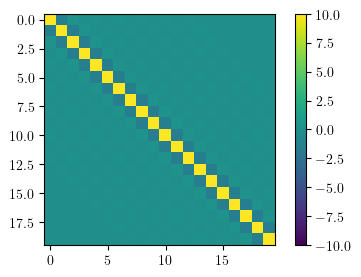

In [16]:
from numpy.linalg import inv
ainv = inv(cov)
pksflare_dataset_sys.penalising_invcovmatrix = ainv

fig, (ax1) = plt.subplots(figsize=(5, 3), ncols=1)
pos =plt.imshow(ainv, vmin = -10, vmax = 10)
fig.colorbar(pos, ax=ax1)

In [17]:
%%time
fit_sys = Fit()
fit_sys.run(pksflare_dataset_sys)

CPU times: user 4min 57s, sys: 2min 10s, total: 7min 8s
Wall time: 7min 9s


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : False
	message    : Optimization failed. Call limit was reached.
	nfev       : 6228
	total stat : 198845.31

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

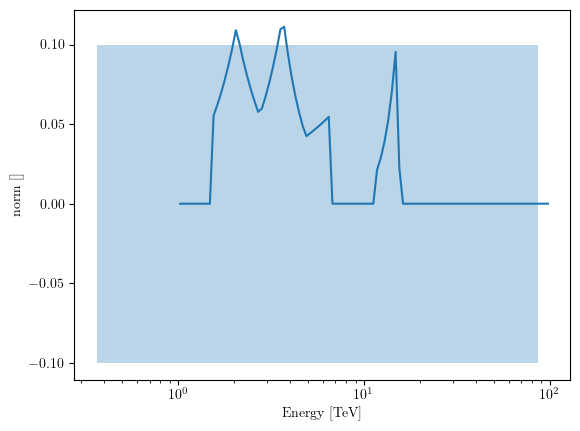

In [21]:
pksflare_dataset_sys.models[1].spectral_model.model1.plot([1,100]*u.TeV)
plt.fill_between(energy.value, sys_percentage[emask]/100,-sys_percentage[emask]/100,
                alpha = 0.3)

plt.yscale("linear")

/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1134: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


(<WCSAxes: >,
 <Axes: xlabel='Energy [TeV]', ylabel='Residuals ((data - model) / sqrt(model))'>)

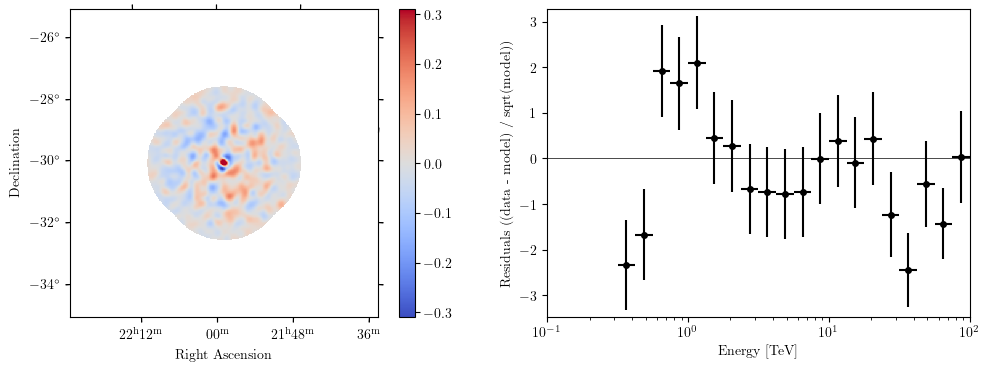

In [22]:
pksflare_dataset_sys.plot_residuals(kwargs_spatial={'vmax':0.31,
                                      'vmin':-0.31},
                      kwargs_spectral={'method' : 'diff/sqrt(model)'})

/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1134: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1134: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


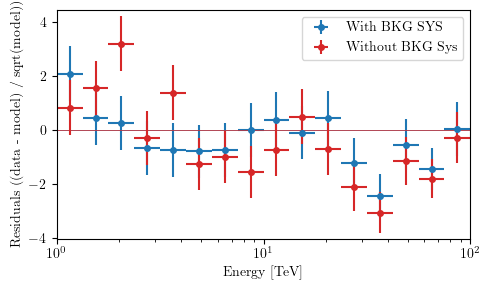

In [23]:
fig, ax = plt.subplots(figsize = (5,3))
ax = pksflare_dataset_sys.plot_residuals_spectral(method =  'diff/sqrt(model)', color = 'tab:blue',
                                             label = "With BKG SYS")
pksflare_dataset.plot_residuals_spectral(method =  'diff/sqrt(model)', color = 'tab:red', ax = ax,
                                    label = "Without BKG Sys")
#plt.fill_between(energy.value, sys_percentage[emask],-sys_percentage[emask],alpha = 0.3)
ax.legend()
ax.set_xlim(1,100)
plt.tight_layout()

fig = plt.gcf()
fig.savefig('plots/1_spectracl_res_points.png')

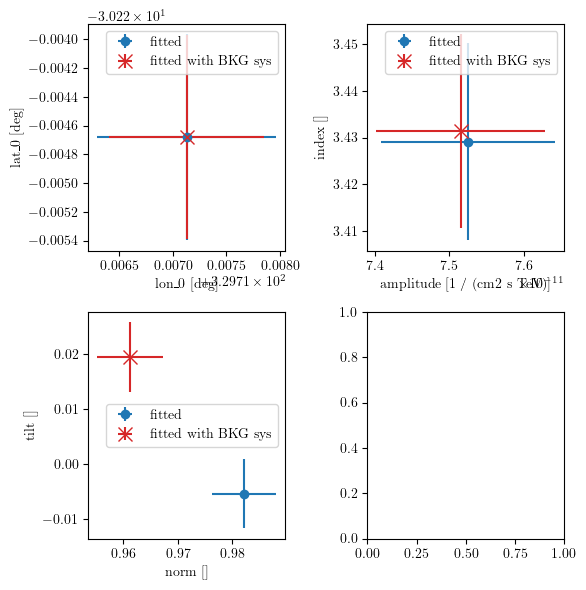

In [24]:
models_list = [ pksflare_dataset.models, pksflare_dataset_sys.models ]
colors = ['tab:blue', 'tab:red', 'tab:green']
pars =  pars = [('lon_0', 'lat_0'),('amplitude', 'index'),
               ('norm', 'tilt')]
ax = plot_source_par(0, pars)


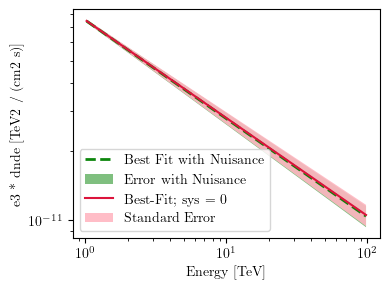

In [27]:
energy_bounds = (1, 100 ) * u.TeV

fig,axs = plt.subplots(1,1,figsize = (4,3))
energy_power=3
#powerlaw_published[0].spectral_model.plot(energy_bounds, energy_power = energy_power, ax =axs, 
#                                label = "Input", color = 'black', linewidth = energy_power, linestyle="dashed")
pksflare_dataset_sys.models[0].spectral_model.plot(energy_bounds,  energy_power = energy_power, ax = axs,color = 'green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)
pksflare_dataset_sys.models[0].spectral_model.plot_error(energy_bounds,  energy_power = energy_power, ax = axs,
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)

pksflare_dataset.models[0].spectral_model.plot(energy_bounds,  energy_power = energy_power, ax = axs,
                                label = "Best-Fit; sys = 0%", color = "crimson")
pksflare_dataset.models[0].spectral_model.plot_error(energy_bounds,  energy_power = energy_power, ax = axs,
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

axs.legend() 
plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2_spectrum_comparison.png")

In [30]:
print(pksflare_dataset.models)

DatasetModels

Component 0: SkyModel

  Name                      : aEaZD8Bs
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      3.429   +/-    0.02             
    amplitude                     :   7.53e-11   +/- 1.2e-12 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.717   +/-    0.00 deg         
    lat_0                         :    -30.225   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : stacked-bkg
  Datasets names            : ['stacked']
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm                          :      0.982   +/-    0.01             
    tilt                          :     -0.005   +/-    0.01             
    referen

In [28]:
print(pksflare_dataset_sys.models)

DatasetModels

Component 0: SkyModel

  Name                      : yL_jOV-J
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      3.431   +/-    0.02             
    amplitude                     :   7.52e-11   +/- 1.1e-12 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.717   +/-    0.00 deg         
    lat_0                         :    -30.225   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : Crab sys-bkg
  Datasets names            : ['Crab sys']
  Spectral model type       : CompoundNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm0                         :     -0.030   +/-    0.00             
    norm1                         :     -0.053   +/-    0.00             
    norm2

## LimaSign

In [31]:
from gammapy.estimators import ExcessMapEstimator
from scipy.stats import norm


def com_excl_mask_2d(dataset):
    
    excl_regions = []
    box_center = SkyCoord(l=0*u.deg, b=0*u.deg, frame='galactic')
    box = RectangleSkyRegion(center=box_center, width=4*u.deg, height=1.6*u.deg)
    #source_303 = CircleSkyRegion(center=cat['HESS J1745-303'].position, radius=1.2*u.deg)#was0.9
    source_303 = CircleSkyRegion(center=SkyCoord(358.71, -0.64, unit='deg', frame='galactic'), radius=0.9*u.deg)
    excl_regions = [box, source_303]
    geom= dataset.geoms["geom"]
    geom_2d = geom.slice_by_idx(dict(energy=1))
    excl_mask_2d = Map.from_geom(geom_2d, data=geom_2d.region_mask(excl_regions, inside=False).data)
    return excl_mask_2d


def compute_lima(dataset, edges):
        
    thr = 0.1
    estimator = ExcessMapEstimator(
        correlation_radius=corr_radius,
        selection_optional='all',
        energy_edges=edges,
    ) #was 0.1
    result = estimator.run(dataset)
    
    return result
    
def lima1a (dataset, result, title = None):

    if len(result["sqrt_ts"].geom.axes[0].center) ==1: 
        result["sqrt_ts"].plot(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5)
        fig = plt.gcf()
        if title is not None:
            st = plt.suptitle(title + f"\n corr_radius = {corr_radius}")
            st.set_y(0.95)
            fig.subplots_adjust(top=0.85)
            fig.savefig(f"plots/9a-lima-{title}.pdf")
            fig.savefig(f"plots/9a-lima-{title}.svg")
    else:
        
        result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5)
        
        fig = plt.gcf()
        if title is not None:
            st = plt.suptitle(title+ f"\n corr_radius = {corr_radius}")
            st.set_y(0.95)
            fig.subplots_adjust(top=0.85)
            fig.savefig(f"plots/9a-lima-e-{title}.pdf")
            fig.savefig(f"plots/9a-lima-e-{title}.svg")
            
    return fig


    
def lima1b(result, title):    
    
    
    significance_data = result["sqrt_ts"].data
    
    print(result["sqrt_ts"].data.shape[0])


    selection = np.isfinite(significance_data) & ~(significance_data == 0)
    significance_data = significance_data[selection]

    plt.hist(significance_data, density=True, alpha=0.9, color="firebrick", bins=40)
    mu, std = norm.fit(significance_data)

    x = np.linspace(-5, 5, 100)
    p = norm.pdf(x, mu, std)

    plt.plot(x,p,lw=2,color="black",
             label=r"$\mu$ = {:.6f}, $\sigma$ = {:.6f}".format(mu, std),)
    
    
    p = norm.pdf(x, 0, 1)

    plt.plot(x,p,lw=2,color="tab:blue",
             label=r"$\mu$ = {:.3f}, $\sigma$ = {:.3f}".format(0, 1),)
    plt.legend(fontsize=14)
    plt.xlim(-5.5, 5.5)
    ax =plt.gca()
    plt.ylim(1e-4, ax.get_ylim()[1]) 
    plt.yscale('log')
    fig = plt.gcf()
    if title is not None:
        st = plt.suptitle(title + f"\n corr_radius = {corr_radius}")
        #fig.tight_layout()
        
        st.set_y(0.99)
        fig.subplots_adjust(top=0.85)
        fig.savefig(f"plots/9a-lima-dist-{title}.pdf")
        fig.savefig(f"plots/9a-lima-dist-{title}.svg")
        
    
    #pic=pic+1;plt.savefig(f'../tempo/{key}_{pic}.pdf');
    #plt.close() # res dist _6

    
   

In [32]:
corr_radius = 0.1* u.deg
thr = 1
titles = ["With BKG sys", "with out"]

In [33]:
%%time
computing = 1
if computing:
    edges = [thr, 100] * u.TeV
    result_impact = compute_lima (pksflare_dataset_sys,edges)
    result_impact.write(f'data/1_lima_sys_{corr_radius}_deg.fits')    
else:
    from gammapy.estimators.map import FluxMaps
    result_impact= FluxMaps.read(f'data/1_lima_sys_{corr_radius}_deg.fits')

OSError: File exists already: data/1_lima_sys_0.1 deg_deg.fits_model.yaml

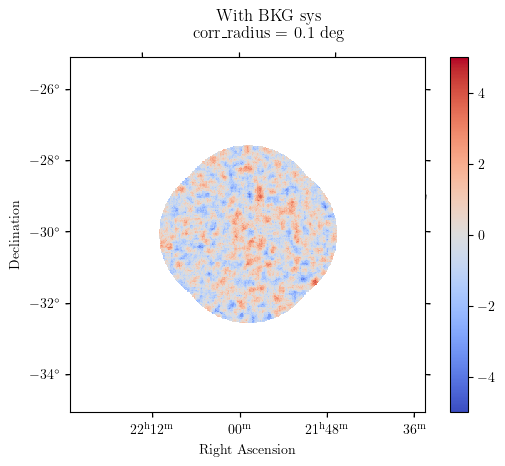

In [34]:
fig = lima1a(pksflare_dataset_sys, result_impact, titles[0])

1


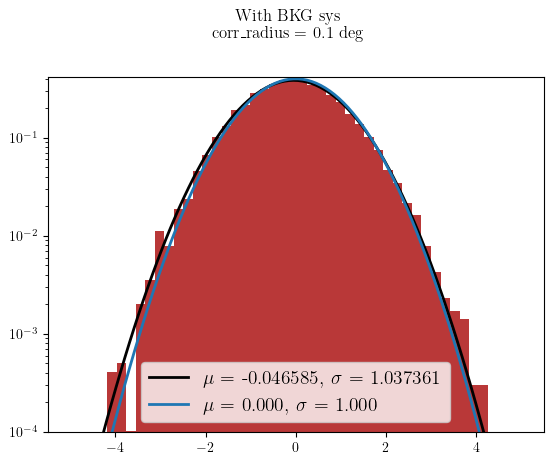

In [35]:
fig = lima1b( result_impact, titles[0])

### without

In [36]:
%%time
computing = 1
if computing:
    edges = [thr, 100] * u.TeV
    result_crab = compute_lima (pksflare_dataset,edges)
    result_crab.write(f'data/1_lima_{corr_radius}_deg.fits')    
else:
    result_crab = FluxMaps.read(f'data/1_lima_{corr_radius}_deg.fits')    
    

OSError: File exists already: data/1_lima_0.1 deg_deg.fits_model.yaml

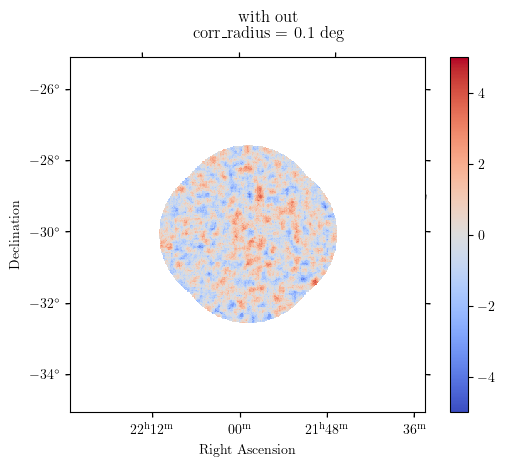

In [37]:
fig = lima1a(pksflare_dataset, result_crab, titles[1])

1


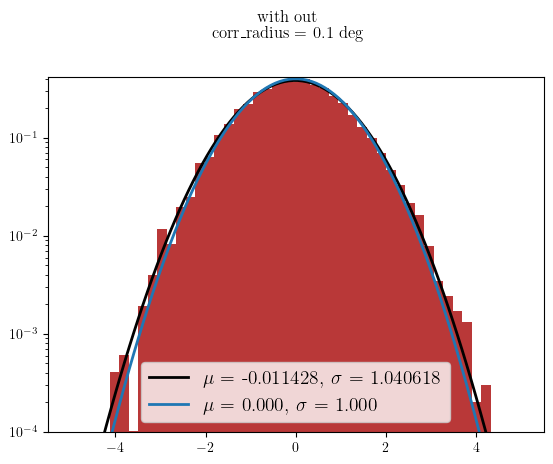

In [38]:
fig = lima1b( result_crab, titles[1])

## Fluxpoints

In [ ]:
%%time
from gammapy.estimators import FluxPointsEstimator

fp_est_sys = FluxPointsEstimator(energy_edges=energy[::3], 
                                 source = crab_dataset_sys.models[0].name)
fp_sys = fp_est_sys.run(crab_dataset_sys)

In [ ]:
%%time
from gammapy.estimators import FluxPointsEstimator

fp_est = FluxPointsEstimator(energy_edges=energy[::3], 
                                 source = crab_dataset.models[0].name)
fp = fp_est.run(crab_dataset)

In [ ]:
from gammapy.datasets import FluxPointsDataset
fp_dataset = FluxPointsDataset(data = fp, 
                              models = crab_dataset.models[0])
fp_dataset.plot_fit()

In [ ]:
fp_sys_dataset = FluxPointsDataset(data = fp_sys, 
                              models = crab_dataset_sys.models[0])
fp_sys_dataset.plot_fit()